
## <center> **CUSTOMER SEGMENTATION AND PREDICTIVE ANALYSIS** </center>

**Project Overview:** Analyzing the AdventureWorks database for customer segmentation using RFM (Recency, Frequency, Monetary) analysis and K-Means clustering.

**Objectives:**  
  - Segment customers based on purchasing behavior.  
  - Predict future sales trends.   
  - Provide actionable insights for business growth.    
___

### **INITIALIZATION**

In [25]:
# Importing necessary libraries, packages, classes, and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from lazypredict.Supervised import LazyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import sqlalchemy


In [38]:
# Connecting to AdventureWorks database on SSMS
conn_str = (
    r'DRIVER={SQL Server};'
    r'SERVER=KRISHNA\SQLEXPRESS;'
    r'DATABASE=AdventureWorks;'
    r'Trusted_Connection=yes;'
)
conn = sqlalchemy.create_engine(f'mssql+pyodbc:///?odbc_connect={conn_str}').connect()

# Using 1 Jan 2014 as snapshot date
snapshot_date = '2014-01-01'

### **DATA RETRIVAL AND RFM CALCULATION**

In [43]:
# Querying the AdventureWorks stored on my local server to extract sales data for RFM calculation
query_rfm = f"""
SELECT c.CustomerID,
       MAX(soh.OrderDate) AS last_purchase,
       COUNT(DISTINCT soh.SalesOrderID) AS frequency,
       SUM(sod.LineTotal) AS monetary
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
WHERE soh.OrderDate < '{snapshot_date}'
GROUP BY c.CustomerID
"""

# Importing data as a DataFrame directly from the server
df = pd.read_sql(query_rfm, conn)

# Displaying the first few rows and basic descriptive statistics
df.head()


,CustomerID,last_purchase,frequency,monetary
0,11012,2013-08-16,1,74.98
1,11013,2013-09-13,1,38.98
2,11014,2013-09-30,2,138.45
3,11021,2013-06-25,1,2371.96
4,11022,2013-06-22,1,2322.28


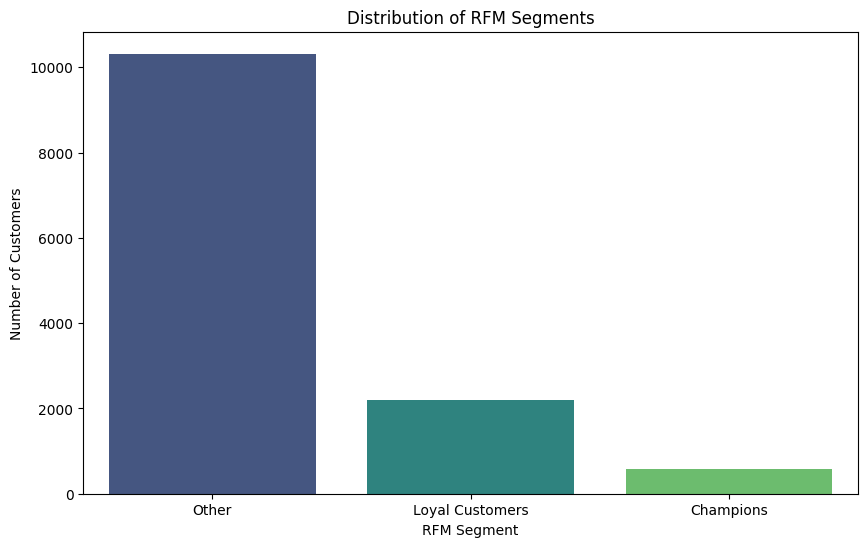

In [28]:
# Calculating recency in days
df['last_purchase'] = pd.to_datetime(df['last_purchase'])
df['recency'] = (pd.to_datetime(snapshot_date) - df['last_purchase']).dt.days

# Assigning RFM scores using quantiles
df['r_score'] = pd.qcut(df['recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
df['f_score'] = pd.qcut(df['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
df['m_score'] = pd.qcut(df['monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combining RFM scores into a single string
df['rfm_score'] = df['r_score'].astype(str) + df['f_score'].astype(str) + df['m_score'].astype(str)

# Createing segments based on RFM score
def assign_segment(row):
    if row['rfm_score'] == '555':
        return 'Champions'
    elif int(row['r_score']) >= 4 and int(row['f_score']) >= 4 :
        return 'Loyal Customers'
    else:
        return 'Other'
df['rfm_segment'] = df.apply(assign_segment, axis=1)

# Visualizing RFM segments
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rfm_segment', palette='viridis')
plt.title('Distribution of RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.show()

**Description**: Recency is calculated as the number of days since the last purchase relative to the snapshot date. RFM scores (1-5) are assigned using quintiles, where higher scores indicate better performance (e.g., lower recency, higher frequency, and monetary values). The scores are combined into an `rfm_score` string, and customers are segmented into 'Champions', 'Loyal Customers', or 'Other' based on predefined rules. A bar plot visualizes the distribution of these segments.

In [29]:
# Querying for future sales (after snapshot date)
query_future = f"""
SELECT c.CustomerID,
       SUM(sod.LineTotal) AS future_sales
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
WHERE soh.OrderDate >= '{snapshot_date}'
AND soh.OrderDate < '2015-01-01'
GROUP BY c.CustomerID
"""
df_future = pd.read_sql(query_future, conn)

# Mergeing future sales with RFM data and fill missing values with 0
df = df.merge(df_future, on='CustomerID', how='left')
df['future_sales'] = df['future_sales'].fillna(0)

# Displaying the last 5 rows
df.tail()

,CustomerID,last_purchase,frequency,monetary,recency,r_score,f_score,m_score,rfm_score,rfm_segment,future_sales
13092,30050,2013-10-30,6,439681.33,63,4,5,5,455,Loyal Customers,119939.62
13093,30072,2013-07-31,1,200.05,154,2,4,2,242,Other,140.10
13094,30102,2013-10-30,3,4394.03,63,4,5,5,455,Loyal Customers,1884.39
13095,30104,2013-02-28,4,5615.58,307,1,5,5,155,Other,0.00
13096,30113,2013-10-30,6,216553.29,63,4,5,5,455,Loyal Customers,56632.60


### **CUSTOMER SEGMENTATION USING K-MEANS CLUSTERING**

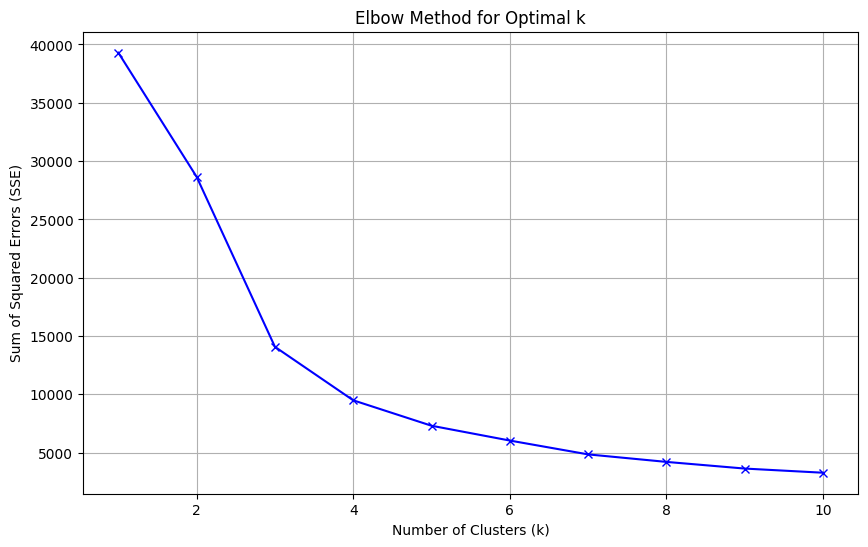

In [30]:
# Prepare data for clustering
X = df[['recency', 'frequency', 'monetary']]

# Scale the input variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use the Elbow method to identify the optimal number of clusters
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse[k] = kmeans.inertia_

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


**Description**: 
- Features for clustering (recency, frequency, monetary) are selected and standardized using StandardScaler to ensure equal weighting. 
- The Elbow method is used to determine the optimal number of clusters by calculating the sum of squared errors (SSE) for k values from 1 to 10.
- The resulting plot helps identify the "elbow" point where additional clusters yield diminishing returns and we can clearly see that after 3 seems to be the optimal cluster count.

In [31]:
# Apply K-Means with the optimal number of clusters
optimal_clusters = 3  # Determined from the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Calculate cluster characteristics
cluster_characteristics = df.groupby('cluster').agg(
    avg_recency=('recency', 'mean'),
    avg_frequency=('frequency', 'mean'),
    avg_monetary=('monetary', 'mean'),
    customer_count=('CustomerID', 'count')
).reset_index()
cluster_characteristics

,cluster,avg_recency,avg_frequency,avg_monetary,customer_count
0,0,622.71,1.07,3671.50,2023
1,1,103.97,1.44,2528.42,10840
2,2,74.06,8.47,234841.60,234


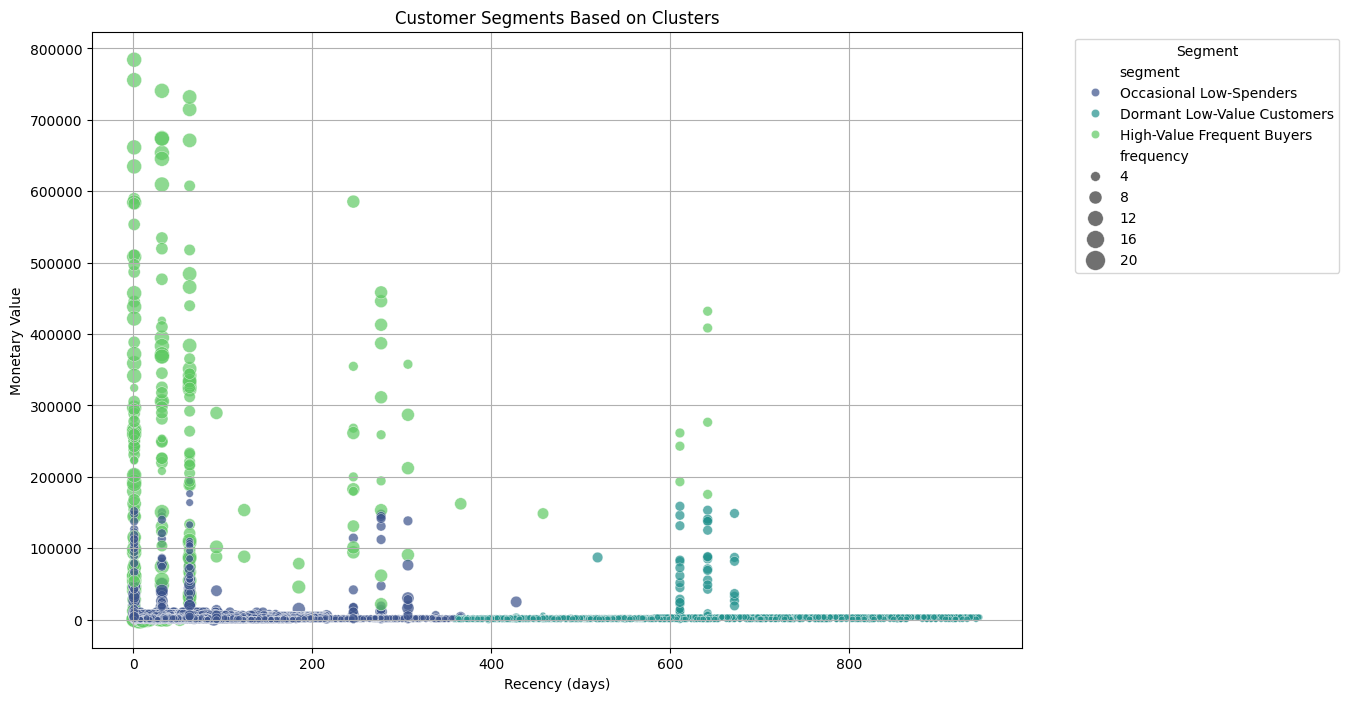

In [32]:
# Defining mapping based on cluster attributes
cluster_labels = {
    0: "Dormant Low-Value Customers",
    1: "Occasional Low-Spenders",
    2: "High-Value Frequent Buyers"
}

# Assigning labels
df['segment'] = df['cluster'].map(cluster_labels)


# Visualizing clusters using a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df['recency'], 
    y=df['monetary'], 
    hue=df['segment'], 
    size=df['frequency'], 
    sizes=(20, 200), 
    palette='viridis', 
    alpha=0.7
)
plt.title('Customer Segments Based on Clusters')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


### **SALES PREDICTION**

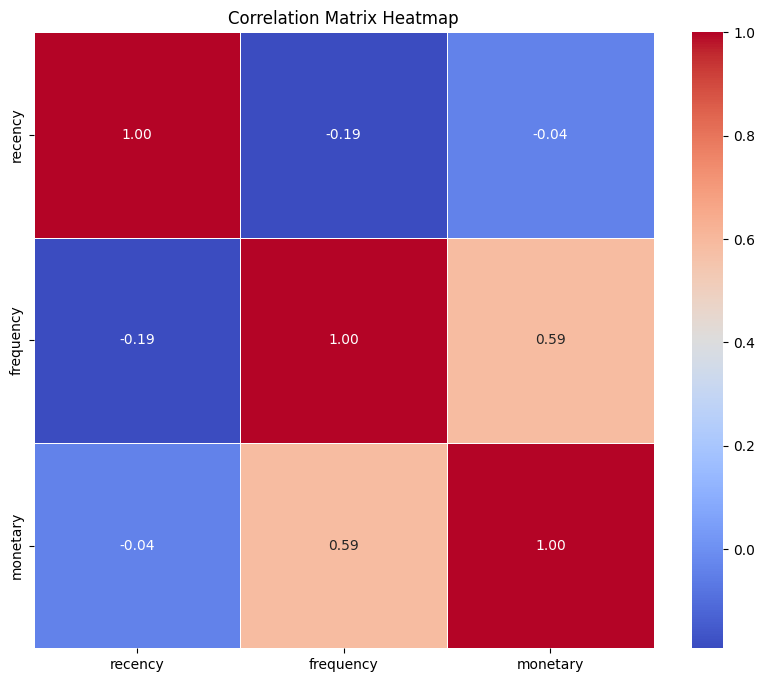

In [33]:
# Calculate the correlation matrix
correlation_matrix = df[['recency','frequency','monetary']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [34]:
# Features and target for sales prediction
X_sales = df[['recency', 'frequency', 'monetary']]
y_sales = df['future_sales']

# Split data into training and testing sets
X_train_sales, X_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, y_sales, test_size=0.2, random_state=42)

# Create a pipeline with an imputer and LazyRegressor
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
)

# Fit the pipeline and identify the best model
lazy_reg = pipeline.named_steps['lazyregressor']
models_sales, predictions_sales = lazy_reg.fit(X_train_sales, X_test_sales, y_train_sales, y_test_sales)

# Select the best model based on R² score
best_model_name_sales = models_sales.sort_values(by='R-Squared', ascending=False).iloc[0].name
best_model_sales = lazy_reg.models[best_model_name_sales]

# Train and evaluate the best model
best_model_sales.fit(X_train_sales, y_train_sales)
y_pred_sales = best_model_sales.predict(X_test_sales)

# Calculate error metrics
mae_sales = mean_absolute_error(y_test_sales, y_pred_sales)
r2_sales = r2_score(y_test_sales, y_pred_sales)
print(f"Best Sales Prediction Model: {best_model_name_sales}")
print(f"MAE: {mae_sales:.2f}")
print(f"R² Score: {r2_sales:.2f}")

# Add predictions to DataFrame
df['predicted_future_sales'] = best_model_sales.predict(X_sales)


100%|██████████| 42/42 [01:04<00:00,  1.53s/it]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 10477, number of used features: 3
[LightGBM] [Info] Start training from score 1306.570842
Best Sales Prediction Model: RandomForestRegressor
MAE: 648.89
R² Score: 0.83


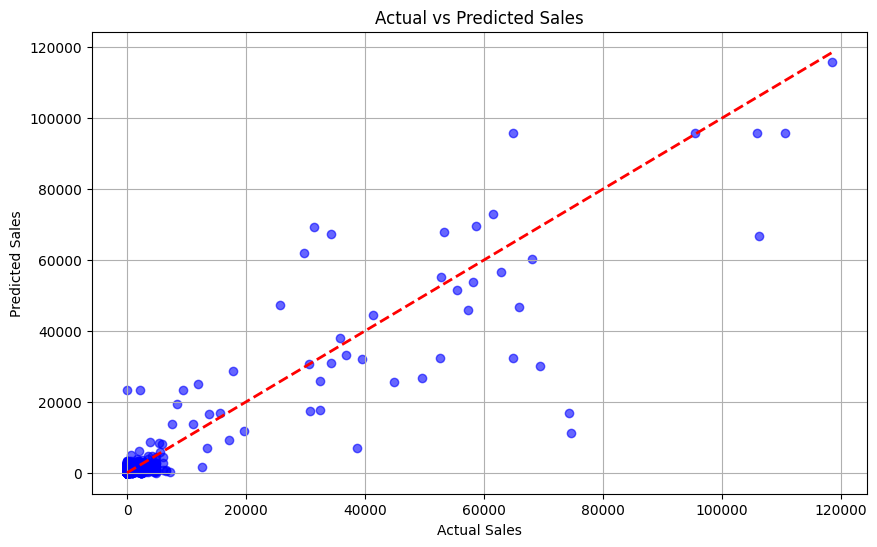

In [35]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_sales, y_pred_sales, alpha=0.6, color='blue')
plt.plot([y_test_sales.min(), y_test_sales.max()], [y_test_sales.min(), y_test_sales.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.show()

### **EXPORTING RESULTS**

In [36]:
# Select relevant columns for export
df_result = df[['CustomerID', 'recency', 'frequency', 'monetary', 
                'rfm_score', 'rfm_segment', 'segment', 'future_sales', 
                'predicted_future_sales']]

# Export to CSV
df_result.to_csv('customer_advanced_analysis.csv', index=False)

# Close the database connection
conn.close()

print("Analysis complete. Results saved to 'customer_advanced_analysis.csv' for PowerBI.")

Analysis complete. Results saved to 'customer_advanced_analysis.csv' for PowerBI.


### **ACTIONABLE INSIGHTS**

 1. **Champions and Loyal Customers**: Focus retention efforts on these high-value segments with personalized offers and loyalty programs.
 2. **Occasional Big Spenders**: Encourage more frequent purchases through targeted promotions or bundles.
 3. **Low-Value Infrequent Buyers**: Re-engage these customers with low-cost incentives or reactivation campaigns.
 4. **Churn Prevention**: Prioritize customers with high churn probabilities (>0.7) for immediate outreach.
 5. **Sales Forecasting**: Use predicted future sales to optimize inventory and marketing budgets.